In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision.models import vgg16

from src.data.vimeo_dataset import Vimeo90KDataset
from src.interpolation_utils import naive_interpolate
from src.model import UNet

In [3]:
DATA_ROOT = './data/vimeo90k'
TRAIN_LIST = f'{DATA_ROOT}/tri_trainlist.txt'
TEST_LIST = f'{DATA_ROOT}/tri_testlist.txt'
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_train = Vimeo90KDataset(DATA_ROOT, TRAIN_LIST, transform=train_transform)
dataset_test  = Vimeo90KDataset(DATA_ROOT, TEST_LIST,  transform=train_transform)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
loader_test  = DataLoader(dataset_test,  batch_size=1, shuffle=False)

In [5]:
class PerceptualLoss(nn.Module):
    def __init__(self, layers=['features.3', 'features.8', 'features.15']):
        super().__init__()
        vgg = vgg16(pretrained=True).features
        self.selected_layers = layers
        self.vgg = nn.Sequential(*list(vgg.children())[:max(int(l.split('.')[-1]) for l in layers)+1]).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        loss = 0.0
        x = pred
        y = target
        idx = 0
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            y = layer(y)
            layer_name = f"features.{idx}"
            if layer_name in self.selected_layers:
                loss += nn.functional.l1_loss(x, y)
            idx += 1
        return loss

In [6]:
model = UNet().to(DEVICE)
perc_loss = PerceptualLoss().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)

c:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\aaron/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 117MB/s]  


In [7]:
train_losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for f1, f2, f3 in loader_train:
        f1, f3, f2 = f1.to(DEVICE), f3.to(DEVICE), f2.to(DEVICE)
        inp = torch.cat([f1, f3], dim=1)
        pred = model(inp)

        loss_l1 = criterion(pred, f2)
        loss_perc = perc_loss(pred, f2)
        loss = loss_l1 + 0.1 * loss_perc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg = total_loss / len(loader_test)
    train_losses.append(avg)
    print(f"Epoch {epoch+1}/{EPOCHS} - Total Loss: {avg:.4f} (L1: {loss_l1.item():.4f}, Perc: {loss_perc.item():.4f})")

torch.save(model.state_dict(), 'unet_interp.pth')

Epoch 1/5 - Total Loss: 0.1766 (L1: 0.0606, Perc: 0.3217)
Epoch 2/5 - Total Loss: 0.1346 (L1: 0.0796, Perc: 0.9597)


KeyboardInterrupt: 

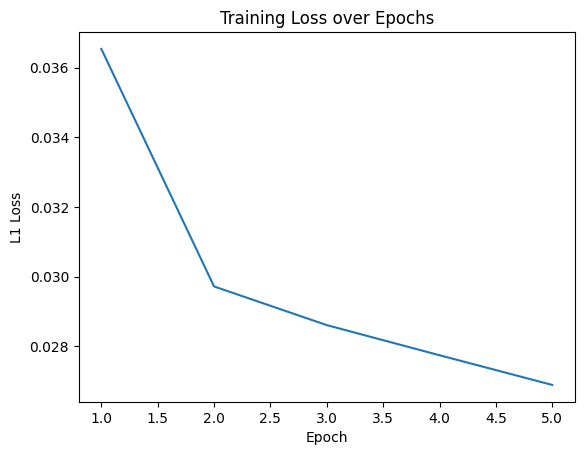

In [ ]:
torch.save(model.state_dict(), 'interpnet_trained.pth')

# Plot training loss
global_step = list(range(1, EPOCHS+1))
plt.figure()
plt.plot(global_step, train_losses)
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Training Loss over Epochs')
plt.show()


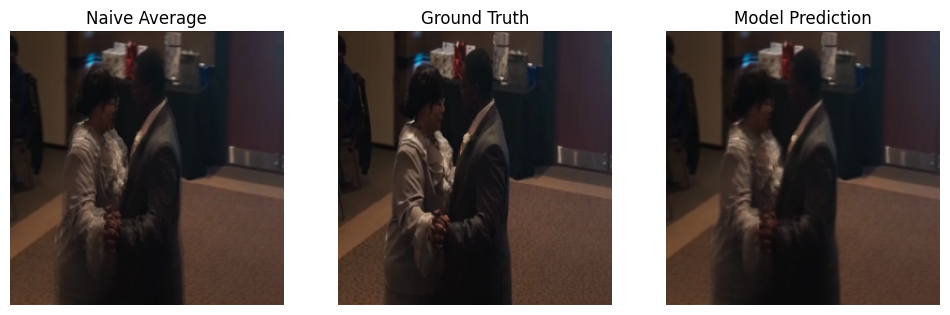

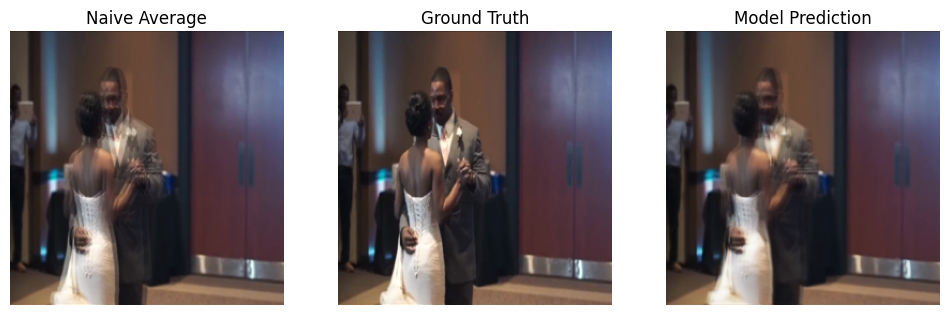

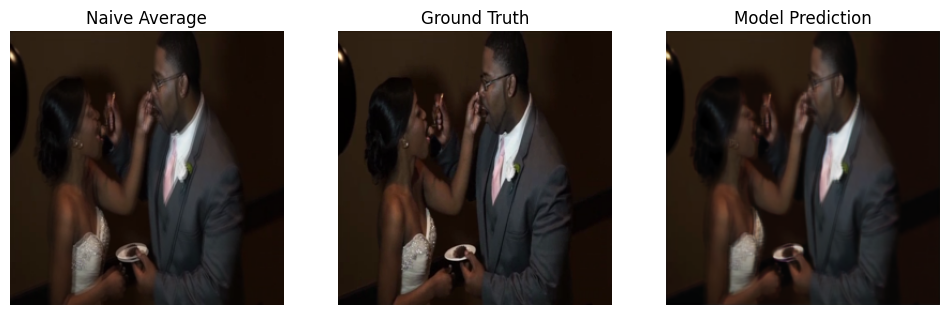

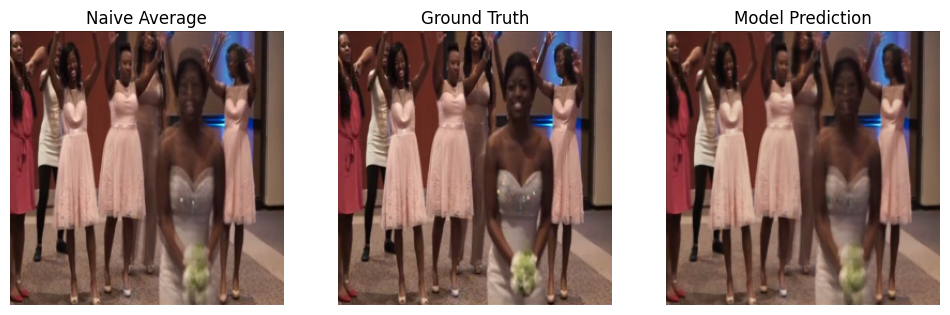

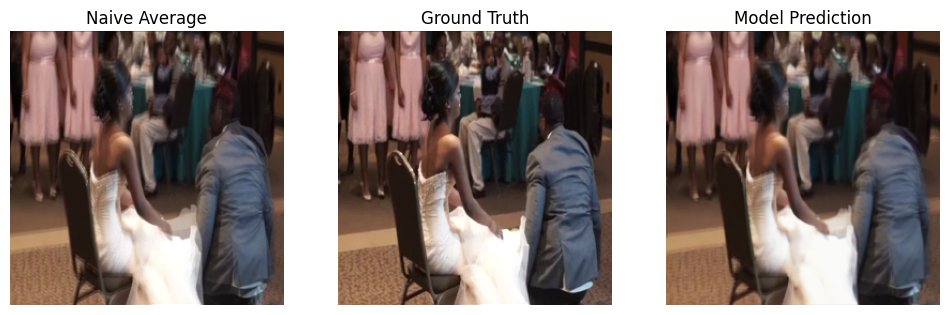

In [ ]:
model.eval()
with torch.no_grad():
    for idx, (f1, f2, f3) in enumerate(loader_test):
        if idx >= 5:  # show first 5 examples
            break
        # prepare input
        inp = torch.cat([f1, f3], dim=1).to(DEVICE)
        pred = model(inp)[0].cpu()
        # denormalize and convert to numpy
        pred_img = (pred.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        gt_img   = (f2[0].permute(1,2,0).numpy() * 255).astype(np.uint8)
        naive_img = np.array(naive_interpolate(Image.fromarray((f1[0].permute(1,2,0).numpy()*255).astype(np.uint8)),
                                              Image.fromarray((f3[0].permute(1,2,0).numpy()*255).astype(np.uint8))))

        # display
        fig, axes = plt.subplots(1, 3, figsize=(12,4))
        axes[0].imshow(naive_img)
        axes[0].set_title('Naive Average')
        axes[0].axis('off')
        axes[1].imshow(gt_img)
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        axes[2].imshow(pred_img)
        axes[2].set_title('Model Prediction')
        axes[2].axis('off')
        plt.show()